In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import program_functions as pf
from scipy import ndimage as nd
import program_functions as pf
%matplotlib inline

In [11]:
# Now we can begin machine learning with pre-labeled images
crop_img = cv2.imread('images/crop_orig.png', 0)

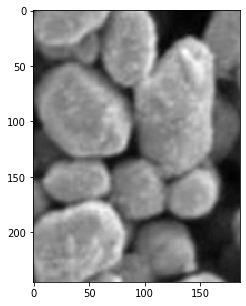

In [12]:
plt.figure(figsize = (5,5))
plt.imshow(crop_img, cmap = 'gray')
plt.show()

In [13]:
df = pf.get_features(crop_img)

In [14]:
#The dataframe should have 62 feature variables, please double check that this is so
df

,pixel,Gabor1,Gabor2,Gabor3,Gabor4,Gabor5,Gabor6,Gabor7,Gabor8,Gabor9,...,Scharr_Edge,Prewitt_Edge,Gaussian3,Gaussian5,Gaussian7,Gaussian9,Median3,Median5,Median7,Median9
0,60,0,0,141,111,3,2,0,0,0,...,0.0,0.0,89,104,111,115,63,71,83,89
1,71,0,0,200,157,59,46,36,28,0,...,0.0,0.0,91,104,112,116,71,74,83,89
2,84,0,0,255,204,79,63,38,30,0,...,0.0,0.0,95,105,112,116,84,88,89,95
3,95,0,0,255,236,95,75,45,36,0,...,0.0,0.0,99,107,113,116,95,101,102,104
4,104,0,0,255,254,102,80,49,39,0,...,0.0,0.0,104,109,113,116,104,108,109,111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45565,34,0,0,100,79,28,22,13,10,0,...,0.0,0.0,37,39,42,45,37,37,38,38
45566,37,0,0,105,84,28,23,10,9,0,...,0.0,0.0,36,38,41,44,37,37,37,37
45567,37,0,0,116,92,44,35,28,22,0,...,0.0,0.0,36,38,40,43,37,37,37,37
45568,36,0,0,94,75,22,18,6,6,0,...,0.0,0.0,35,37,40,43,36,34,36,37


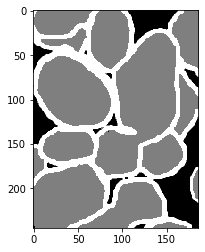

In [16]:
#Now add class label column by importing the pre-label image
img_class = cv2.imread('images/crop_final.png', 0)
plt.imshow(img_class, cmap = 'gray')

In [19]:
#Reshape to 1-D array and check if the length matches the rows of the dataframe table
img_reshape = img_class.reshape(-1)
print(len(img_reshape))

45570


In [20]:
# Check to make sure the pre-label image only has 3 class labels (unique pixel values)
df['class'] = img_reshape
df['class'].value_counts()

127    30548
255     9884
0       5138
Name: class, dtype: int64

In [21]:
# df = pd.concat([df1,df2], axis = 0)
# df.reset_index(drop=True, inplace = True)

In [23]:
#Now we are ready to train and test the machine learning model

In [49]:
# Do 90:10 train:test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,0:-1].values, df.iloc[:,-1].values, test_size = 0.2, random_state = 10)

In [50]:
# No standard scaling is necessary since every feature variable has the same range of values from 0 to 255. 

In [51]:
#The machine learning algorithm to use for this model (Random Forest Classifier)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 150, min_samples_split = 2, n_jobs = -1, random_state = 10, verbose = 0)

In [52]:
model.fit(x_train, y_train)

RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=10)

In [53]:
# Predicted pixel values
y_pred = model.predict(x_test)

In [54]:
# Compare to see how many matches with the real test pixel values
matches = [1 if i==j else 0 for i,j in zip(y_pred,y_test)]

In [55]:
def get_acc(matches):
    return sum(matches)/len(matches)

In [56]:
# The predictino accuracy is 93% for this example
get_acc(matches)

0.9333991661180602

In [57]:
# Since Random Forest Classifier performs intrinsic feature selection, we can check which features it placed the most importance on

In [58]:
feat_list = pd.DataFrame()
feat_list['Features'] = df.columns[:-1]
feat_list['Impt Score'] = model.feature_importances_
feat_list = feat_list.sort_values('Impt Score', ascending = False).reset_index(drop=True)
feat_list.head(n=10)

,Features,Impt Score
0,Roberts_Edge,0.067825
1,Sobel_Edge,0.065671
2,Prewitt_Edge,0.065099
3,Gabor6,0.055355
4,Scharr_Edge,0.053624
5,Gabor5,0.045228
6,Median5,0.041453
7,Gabor24,0.037750
8,Median9,0.035841
9,Gabor7,0.029316


In [287]:
#Storing model for future use in Pickle format

In [158]:
filename = 'particle_ml.pickle'
#Write in binary format
pickle.dump(model, open(filename, 'wb'))

In [159]:
#Now pretend want to use it back
filename = 'particle_ml.pickle'
#Read binary format
model = pickle.load(open(filename, 'rb'))

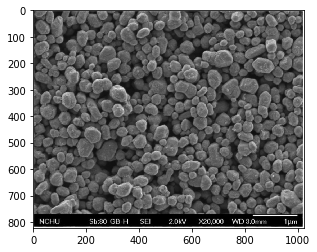

In [59]:
#Now we are ready to use the model on the full version of the sem particle image
img_test = cv2.imread('images/sem_particle_nano1.png',0)
plt.imshow(img_test, cmap = 'gray')

In [60]:
# Again, let's get the 62 feature variables
df_test = pf.get_features(img_test)

In [61]:
y_pred = model.predict(df_test.values)

In [62]:
# Check the prediction results. There should only be 3 unique color pixels if the model was trained with 3 class labels.
pd.Series(y_pred).value_counts()

127    418185
255    296691
0      126852
dtype: int64

In [63]:
# Since the prediction is in a 1-D array, we need to reshape it back into a 2-D array image
orig_img_shape = img_test.shape
segmented_img = y_pred.reshape(img_test.shape)

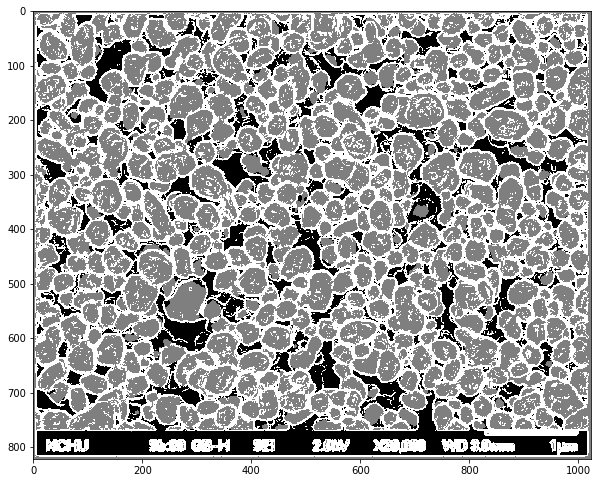

In [64]:
plt.figure(figsize = (10,10))
plt.imshow(segmented_img, cmap='gray', alpha = 1)

In [256]:
# Alright, semantic segmentation is done. Now let's save this image to perform instance segmentation.
plt.imsave('images/segmented_image.jpg', segmented_img, cmap = 'gray')